# The Role of Stochasticity in the Evolution of Animal Pattern and Morphology

In [1]:
# Import relevant modules
%matplotlib inline
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from sys import maxsize
from time import perf_counter # [1]


In [2]:
isParallel = maxsize > 2 ** 31 # [2]
morphogenLeftConc = 1

# Thresholds
changeThreshold = 1e-3
unstabilityThreshold = 1
phenotypeThreshold = 1e-1

mechanismIndex = 2
subIndex = 0

# Writing to files?
writeAny = np.zeros((6, 2)) == 0


writeAny[0,1] = False # <30min, 8min, 101.356min, 25.356min, 21.2185min,247.83min,78.92564582min, 304.870527978min
writeAny[1,1] = False # 43min
writeAny[2,1] = False # 138/246min
writeAny[5,1] = True # 42min

writeAny[:,0] = True
writeAny[:,1] = False

writeDeviations = writeAny[mechanismIndex, 0]
writeConvergence = writeAny[mechanismIndex, 1]

In [3]:
geneIndexTranslation = {
    0 : 'r',
    1 : 'b',
    2 : 'g'
}

Equation to solve:
$$\frac{dg_{ij}}{dt} = \chi\Big(\phi\Big(\sum\limits_{l=1}^{N_g} W^{li}g_{lj} + M\Big)\Big) + D_i \nabla^2 g_{ij} - \lambda g_{ij} + \eta(t) g_{ij}$$

$$dg_{ij} = \frac{\partial g_{ij}}{\partial t} dt + \frac{\partial g_{ij}}{\partial x} dx$$
$$\frac{dg_{ij}}{dt} = \frac{\partial g_{ij}}{\partial t} + \frac{\partial g_{ij}}{\partial x} \frac{dx}{dt}$$

$$\frac{g_{i,n+1} - g_{i,n}}{\Delta t} = D \frac{g_{i-1,n} - 2g_{i,n} + g_{i+1,n}}{(\Delta x)^2} + \chi(\phi(\omega_{i,n} + M_i)) - \lambda g_{i,n}$$

$$g_{i,n+1} = g_{i,n} \Big( 1 - \frac{2D\Delta t}{(\Delta x)^2} - \lambda \Delta t \Big) + \frac{D\Delta t}{(\Delta x)^2} (g_{i-1,n} + g_{i+1,n}) + \Delta t \chi(\phi(\omega_{i,n} + M_i))$$

Initially have $\eta(t) = 0$ and implement later.



$$
\chi(x) = 
\begin{cases}
    0 \,\,;\, x<0 \\
    x \,\,;\, x>0 \\
\end{cases}
$$

Michaelis-Menten:
$$\phi_{MM}(I) = \frac{I}{K+I}$$
where $K$ is the dissociation constant set to $1$.


Zero flux boundary conditions between cells i.e. isolated.

In simplest diffusion equation require relation, $D \Delta t < (\Delta x)^2$ to be satisfied.

In [4]:

@njit('f8[:](f8[:])')
def chi(x:np.ndarray) -> np.ndarray:
    """
    Heaviside function (step-function)
    
    Inputs:
        - x:float: Value to evaluate at.
    Outputs:
        - x:float: Step-function value of x.
    """

    x[x<0] = 0
    
    return x

@njit('f8[:](f8[:], f8)', fastmath=True)
def phi_MM(x:np.ndarray, dissociationConst:float) -> np.ndarray:
    """
    Michaelis-Menten regulatory function.
    
    Inputs:
        - x:float: Value to evaluate the function at.
        - dissociationConst:float: Value to adjust the function
                                   by in accordance with the highest morphogenConcentration
    Outputs:
        - y:float: Function evaluated at x.
    """
    
    y = x/(dissociationConst + x)
    
    return y
    



Types of mechanisms (each value in matrix has magnitude in range $0-10$):

* Bistable
$$
\begin{pmatrix}
    0 & 0 & 0 \\
    0 & 1 & -1 \\
    -1 & 1 & 0 \\
\end{pmatrix}
$$
* Mutual inhibition
$$
\begin{pmatrix}
    0 & 0 & 0 \\
    1 & 0 & -1 \\
    1 & -1 & 0 \\
\end{pmatrix}
$$
* Classical
$$
\begin{pmatrix}
    0 & 0 & 0 \\
    -1 & 1 & 0 \\
    -1 & -1 & 1 \\
\end{pmatrix}
$$
* Incoherent feed-forward
$$
\begin{pmatrix}
    0 & 0 & 0 \\
    1 & 0 & 0 \\
    1 & -1 & 1 \\
\end{pmatrix}
$$
* Overlapping domains
$$
\begin{pmatrix}
    0 & 0 & -1 \\
    1 & 0 & 0 \\
    -1 & 1 & 0 \\
\end{pmatrix}
$$
* Frozen oscillator
$$
\begin{pmatrix}
    1 & 0 & 0 \\
    -1 & 0 & 1 \\
    -1 & -1 & 1 \\
\end{pmatrix}
$$

$$
\begin{pmatrix}
    M->r & r->r & b->r & g->r \\
    M->b & r->b & b->b & g->b \\
    M->g & r->g & b->g & g->g \\
\end{pmatrix}
$$

In [5]:
@njit('f8[:,:,:](f8[:,:], u8, u8, f8, f8, f8[:], f8, f8[:,:], f8[:], u8, u8, f8[:])',
      fastmath=True)
def explicit_solver(geneInitial:np.ndarray, Nspace:int, Nsteps:int,
                    dx:float, dt:float, diffConst:tuple, decayConst:float,
                    interactionWeights:np.ndarray, morphogenProfile:np.ndarray, numOfSnapshots:int,
                    snapshotPeriod:int, dissociationConsts:np.ndarray) -> np.ndarray:
    """
    Updates concentration using a finite difference approach
    and records the concentration profile at different times.
    
    Inputs:
        - geneIntitial:np.ndarray: Initial gene concentration profile
        - Nspace:int: Number of spatial points used.
        - Nsteps:int: Number of time steps the system is incremented.
        - dx:float: Grid spacing
        - dt:float: Time step
        - diffConst:tuple: Diffusion coefficients
        - decayConst:float: Decay rate <0
        - interactionWeights:np.ndarray: Gene interaction matrix
        - morphogenProfile:np.ndarray: Morphogen concentration profile
        - numOfSnapshots:int: The number of samples to take.
        - snapshotPeriod:int: Steps separating the snapshots.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        
    Outputs:
        - geneHistory:np.ndarray: Values of the concentration at certain instances for all three genes
    """
    
    
    geneHistory = np.zeros((3,numOfSnapshots, Nspace))
    # Creates two arrays to alternate between.
    geneEven = np.copy(geneInitial)
    geneOdd = np.zeros_like(geneInitial)
    
    for n in range(1, Nsteps-1):
        if n%2 == 0:
            for c, gene in enumerate(geneOdd):

                sumProd_Wg = np.ascontiguousarray(interactionWeights[c,1:])@np.ascontiguousarray(geneOdd) # np.dot(interactionWeights[c,1:],gene)


                geneEven[c] = (gene*(1 - 2*diffConst[c]*dt/(dx*dx) - decayConst*dt) 
#                                   + diffConst[c]*dt/(dx*dx)*(np.roll(gene, 1) + np.roll(gene, -1)) 
                                  + dt*phi_MM(chi(sumProd_Wg + interactionWeights[c,0]*morphogenProfile),
                                               dissociationConsts[c]))


            # No flux boundary conditions # [3]
            geneEven[:,0] = geneEven[:,1]
            geneEven[:,-1] = geneEven[:,-2]

        elif n%2 == 1:
            for c, gene in enumerate(geneEven):
                sumProd_Wg = np.ascontiguousarray(interactionWeights[c,1:])@np.ascontiguousarray(geneEven) # np.dot(interactionWeights[c,1:],geneOdd)


                geneOdd[c] = (gene*(1 - 2*diffConst[c]*dt/(dx*dx) - decayConst*dt) 
#                                   + diffConst[c]*dt/(dx*dx)*(np.roll(gene, 1) + np.roll(gene, -1)) 
                                  + dt*phi_MM(chi(sumProd_Wg + interactionWeights[c,0]*morphogenProfile),
                                               dissociationConsts[c]))


            # No flux boundary conditions
            geneOdd[:,0] = geneOdd[:,1]
            geneOdd[:,-1] = geneOdd[:,-2]
        
       
        # Save the current concentration profile
        if (n+1) % snapshotPeriod == 0:
            geneHistory[:,int((n-1)/snapshotPeriod)] = geneEven if (n-1)%2==0 else geneOdd


        # Determines how much the solution is changing
        maxAbsoluteChange = max(np.sum(np.abs(geneEven - geneOdd), axis=1))
        greatestChange = np.amax(np.abs(geneEven - geneOdd))

        if maxAbsoluteChange < changeThreshold:
            geneHistory[:,-1] = geneEven if n%2==0 else geneOdd
            
            return geneHistory

        elif greatestChange > unstabilityThreshold:
            print('Deteriorating solution')
            print('n =',n)
            print('dc =',greatestChange)
            _arg = np.asarray(np.argwhere(np.abs(geneEven - geneOdd) == greatestChange))
            print(_arg)
            for a in _arg:
                print(a, geneEven[a[0],a[1]], geneOdd[a[0],a[1]])

            print('-----------')

            geneHistory[:,-1] = geneEven if n%2==0 else geneOdd
            
            return geneHistory

        
    print('Stability not reached for W=',interactionWeights)
    
    
    return geneHistory


@njit('f8[:](u8, u8, f8, f8, f8, f8)')
def determineMorphogenProfile(Nspace:int, Nsteps:int,
                          dx:float, dt:float, diffConst:float,
                          decayConst:float) -> np.ndarray:
    """
    Determine the morphogen profile by solving the diffusion equation.
    
    Inputs:
        - Nspace:int: Spatial points.
        - Nsteps:int: Number of time steps.
        - dx:float: Spatial separation.
        - dt:float: Time step.
        - diffConst: Diffusion coefficient for the morphogens.
        - decayConst: Degredation constant.

        
    Outputs:
        - concHistory:np.ndarray: The concentration profile at different snapshots.
    """
    
    # Creates array to store morphogen inputs
    morphogenInputs = np.empty(Nspace)
    
    # Creates two arrays to alternate between.
    concEven = 0.1*np.ones(Nspace)
    concOdd = np.empty(Nspace)
    
    for n in range(1, Nsteps-1):
        if n%2 == 0:
            concEven = (concOdd*(1 - 2*diffConst*dt/(dx*dx) - decayConst*dt) 
                            + diffConst*dt/(dx*dx) * (np.roll(concOdd,1) + np.roll(concOdd,-1)))
            # No flux boundary conditions
            concEven[0] = concEven[1] + dx*morphogenLeftConc
            concEven[-1] = concEven[-2]

        elif n%2 == 1:
            concOdd = (concEven*(1 - 2*diffConst*dt/(dx*dx) - decayConst*dt) 
                            + diffConst*dt/(dx*dx) * (np.roll(concEven, 1) + np.roll(concEven,-1)))
            # No flux boundary conditions
            concOdd[0] = concOdd[1] + dx*morphogenLeftConc
            concOdd[-1] = concOdd[-2]
        
    # End assignment
    if Nsteps%2 == 0:
        morphogenInputs = concEven
    elif Nsteps%2 == 1:
        morphogenInputs = concOdd

        
    return morphogenInputs


In [6]:
def displayConcentrationProfile(xPoints:np.ndarray, geneHistory:np.ndarray, dx:float, dt:float,
                                Nspace:int, Nsteps:int, Ncells:int,
                                numOfSnapshots:int, snapshotPeriod:int, morphogenProfile:np.ndarray,
                                interactionWeights:np.ndarray):
    """
    Displays the concentration in each gene over all the cells through time.
    
    Inputs:
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - geneHistory:np.ndarray: An array of concentration profiles of all three genes at certain snapshots.
        - dx:float: Cell separation.
        - dt:float: Time step.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps the system is incremented.
        - Ncells:int: The number of cells used.
        - numOfSnapshots:int: The number of samples to take.
        - snapshotPeriod:int: Steps separating the snapshots.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - interactionWeights:np.ndarray: The strengths of the interactions between the genes.
    """

    fig = plt.figure(tight_layout=True, figsize=(8,numOfSnapshots*2))
    fig.suptitle(f'Variation of concentration over time for W = \n{interactionWeights}', y=0.99)

    for i in range(numOfSnapshots):
        ax = fig.add_subplot(int(numOfSnapshots/2),2,i+1)
        # Displays morphogen concentration profile
        ax.plot(xPoints, morphogenProfile, c='orange')
        # Displays all three genes
        for c in range(3):
            ax.plot(xPoints, geneHistory[c,i], c=geneIndexTranslation[c], marker='.')
        ax.grid()
        
        # Creates appropiate labels
        ax.set_xlabel('position [cell]', fontsize=14)
        ax.set_ylabel('concentration', fontsize=14)
        ax.set_title(f'time={dt*snapshotPeriod*(i+1)}', fontsize=14)

    plt.show(fig)

In [7]:
@njit('f8[:,:,:](f8[:], f8[:], f8[:,:], f8,f8,u8,u8,u8,f8[:],f8,u8,u8,f8[:])', fastmath=True)
def calculateGeneHistory(xPoints:np.ndarray, morphogenProfile:np.ndarray, interactionWeights:np.ndarray,
                         dx:float, dt:float,
                         Ncells:int, Nspace:int, Nsteps:int,
                         diffConsts:np.ndarray, decayConst:float,
                         numOfSnapshots:int, snapshotPeriod:int, dissociationConsts:np.ndarray) -> np.ndarray:
    """
    Calculates the concentration of the morphogen input and the subsequent gene concentration profile over time.
    
    Inputs:
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - morphogenProfile:np.ndarray: The morphogen concentration profile
        - interactionWeights:np.ndarray: Weights associatied with a particular mechanism
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - numOfSnapshots:int: The number of time points the data is recorded at.
        - snapshotPeriod:int: Steps separating the snapshots.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        - showTime:bool: Determines if the time should be displayed.
        
    Outputs:
        - geneHistory:np.ndarray: The concentration profile of the genes over time.
    """


    
    satisfactoryParameters = np.asarray([1 - 2*D*dt/(dx*dx) - decayConst*dt > 0 for D in diffConsts]).all()

    if satisfactoryParameters:
        # Initial gene concentrations
        geneInitial = 0.1*np.ones((3,Nspace))




        geneHistory = explicit_solver(geneInitial, Nspace, Nsteps, dx, dt,
                                      diffConsts, decayConst, interactionWeights, morphogenProfile,
                                      numOfSnapshots, snapshotPeriod, dissociationConsts)

    else:
        print('Parameters DO NOT satisfy relation')
        for D in diffConsts:
            print('\tsatisfactoryParameters =', 1 - 2*D*dt/dx**2 - D*dt)
            
            
    return geneHistory



@njit('Tuple((f8,f8))(f8[:], f8[:,:])') # [4]
def calcStripeAttributes(xPoints:np.ndarray, concProfile:np.ndarray) -> (float, float):
    """
    Calculates properties of the stripe.
    
    Inputs:
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - concProfile:np.ndarray: The concentration profile of the genes.
        
    Outputs:
        - pos:float: The position of the stripe.
        - width:float: The position of the stripe.
    """
    
    # Weighted mean (expectation value)
    pos = np.sum(xPoints*concProfile[-1]) / np.sum(concProfile[-1])
    
    # Weighted standard deviation
    width = np.sqrt(np.sum(concProfile[-1]*(xPoints - pos)*(xPoints - pos)) 
                    / np.sum((xPoints - pos)*(xPoints - pos)))

    return pos, width

#### Defines system parameters

In [8]:
mechanisms = np.asarray([[[[1,0,0,0],[0,0,1.2,-1],[0,-1.8,1.4,0]], # Done for stripe
                      [[0.1,0,0,0],[0,0.25,0,-0.07],[0,1.4,-1.4,0]], # Done for stripe
                      [[0.6,0,0,0],[0,-0.5,1.5,0],[0,-0.155,-0.94,1.85]], # Done for stripe###
                      [[0.05,0,0,0],[0,0.2,0,0],[0,1.05,-1.23,0.36]], # Done for stripe
                      [[0.1,0,0,-1.0],[0,1.0,0,0],[0,-3.5,1.6,0]], # Very unstable can't find a stripe.
                      [[0,0.3,0,0],[0,-4,0,0.9],[0.1,-0.5,-2.4,1.95]]], # Done for stripe
                         
                         [[[ 1., 0., 0., 0.],
                         [ 0., 0., 1.19518595, -0.96467051],
                         [ 0., -1.93900801, 1.30696055, 0.]],
                          [[ 0.1,0.,0,0.],
                         [ 0.,0.23616502,0.,-0.1070939],
                         [ 0.,1.00790988, -1.11374534, 0.]],
                         [[ 0.6, 0.,0.,0.],
                         [ 0.,-0.64580638,2.03389793, 0.],
                         [ 0.,-0.21960488, -0.70052253,1.9750326]],
                         [[ 0.05,0.,0.,0.],
                         [ 0.,0.15050532,0.,0.],
                         [ 0.,0.69541435, -1.31022103,0.51751283]],
                          [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[ 0.,0.35942556, 0.,0.],
                         [ 0.,-2.62278181,0.,0.89315311],
                         [ 0.1,-0.49285205, -2.64747114,2.40731514]]],
                        
                        [[[1., 0.,0.,0.],
                         [0.,0.,1.185727,-0.90230463],
                         [0.,-1.09856766,0.72971261,0.]],
                        [[ 0.1, 0., 0., 0.],
                         [ 0.,0.18937202, 0.,-0.04498403],
                         [ 0.,1.46665849, -1.50546175, 0.]],
                        [[ 0.6, 0.,0., 0.],
                         [ 0.,-0.47125083,1.33445864, 0.,],
                         [ 0.,-0.17587921,-0.94535775,1.81608167]],
                        [[ 0.05,0.,0.,0.],
                         [ 0.,0.16005003, 0.,0.],
                         [ 0.,1.11847848, -1.78454107, 0.48657728]],
                        [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                        [[ 0., 0.29656517, 0., 0.],
                         [ 0.,-6.98343177,0.,1.34685764],
                         [ 0.1,-0.74603017, -2.10477746,1.75796606]]],
                        
                        [[[ 1.,0.,0.,0.],
                         [ 0.,0.,1.55518595, -0.97467051],
                         [ 0.,-3.60262305, 2.80090545, 0.]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]]],
                        
                        [[[ 1.,0.,0.,0.],
                         [ 0.,0.,1.20047086, -1.00158104],
                         [ 0.,-5.00018385, 3.95838004, 0.]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]]],
                        
                        [[[ 1.,0.,0.,0.],
                         [ 0.,0.,1.3529907, -1.24939012],
                         [ 0., -2.98967975, 2.2357019, 0.]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]]],
                        
                        [[[ 1.,0.,0.,0.],
                         [ 0.,0.,0.8509942, -0.7879642],
                         [ 0.,-2.73398418,2.47211908, 0.]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]]],
                         
                         [[[ 1.,0.,0.,0.],
                         [ 0.,0.,0.8509942, -0.4879642],
                         [ 0.,-2.73398418,2.47211908, 0.]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]]],
                        
                        [[[1., 0.,0.,0.],
                         [0.,0.,1.285727,-1.00230463],
                         [0.,-1.1,0.8,0.]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]],
                         [[0,0,0,0],[0,0,0,0],[0,0,0,0]]]])

np.save('../data/mechanisms.npy', mechanisms)

In [9]:
# Mechanism
interactionWeights = mechanisms[subIndex,mechanismIndex]
print('W =', interactionWeights)

# Sets system properties
numOfSnapshots = 10
Ncells = 32 # from paper
dx = 1.
dt = 1e-2
Nspace = int(Ncells/dx)
Nsteps = int(1e+5) + 2

diffConsts = np.zeros(4) # 0-0.05
# Sets morphogen diffusion constant
diffConsts[-1] = 6 # Do not change as the stripe being centred depends on it.

decayConst = 1e-1
dissociationConsts = np.ones(3)

xPoints = np.arange(0, Nspace*dx, dx)
# Determines the frequency with which samples are taken
snapshotPeriod = int((Nsteps-2)/numOfSnapshots)

morphogenProfile = determineMorphogenProfile(Nspace, Nsteps, dx, dt, diffConsts[-1], decayConst)

W = [[ 0.6    0.     0.     0.   ]
 [ 0.    -0.5    1.5    0.   ]
 [ 0.    -0.155 -0.94   1.85 ]]


In [10]:
startTime = perf_counter()
geneHistory = calculateGeneHistory(xPoints, morphogenProfile, interactionWeights, dx, dt, Ncells, Nspace, Nsteps,
                                   diffConsts, decayConst, numOfSnapshots,
                                   snapshotPeriod, dissociationConsts)
endTime = perf_counter()

print(f'Time taken = {endTime - startTime} seconds')

initialPhenotypes = calcStripeAttributes(xPoints, geneHistory[-1])
print(initialPhenotypes)

Time taken = 0.30658650000000165 seconds
(14.260454965728192, 0.7696480604022776)


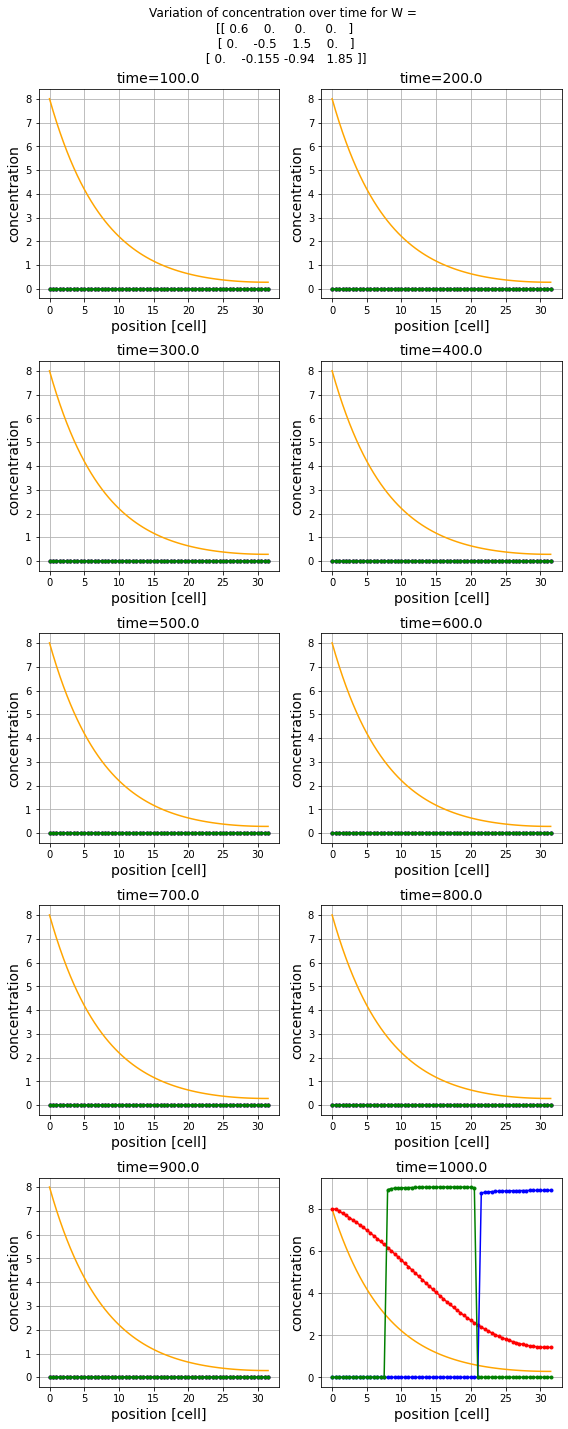

In [11]:
displayConcentrationProfile(xPoints, geneHistory, dx, dt,
                            Nspace, Nsteps, Ncells, numOfSnapshots,
                            snapshotPeriod, morphogenProfile, interactionWeights)



## Introduce mutation

In [12]:
@njit('f8[:,:](f8[:,:])', fastmath=True, parallel=isParallel)
def mutateRandomWeight(interactionWeights:np.ndarray) -> np.ndarray:
    """
    Vary one of the weights by a small percentage.
    
    Inputs:
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
    Outputs:
        - interactionWeights:np.ndarray: Mutated weights.
    """
    
    std = 1e-1
    mean_std = 3
        
    # Determine the position of the weights to vary (excluding morphogen input)
    pos = np.argwhere(interactionWeights[:,1:] != 0)
    pos[:,1] += 1 
    
    # Determine how many weights to vary
    prob = np.random.random()
    numWeights = 1
    for i in range(1, len(pos)):
        if prob < 5**(-i):
            numWeights = i+1
        else:
            break
    
    
    # Determine which weight to vary
    weightsToVary = np.random.choice(np.arange(0, len(pos), 1), size=numWeights, replace=False)
    
    # weightToVary = pos[np.random.randint(len(pos))]
    weights = np.copy(interactionWeights)
    
    for i in weightsToVary:
        # Determine the percentage to vary by.
        amount = std*(mean_std + np.random.randn())

        sign = 1 if np.random.random() < 0.5 else -1 # [5]
        weights[pos[i,0],pos[i,1]] += sign*amount*weights[pos[i,0],pos[i,1]]
    
    return weights




In [13]:
@njit('b1(f8[:])', fastmath=True)
def isStillStripe(concProfile:np.ndarray) -> bool:
    """
    Determines whether the stripe is maintained.
    
    Inputs:
        - concProfile:np.ndarray: 
        
    Outputs:
        - isStripe:bool: Is the stripe still present.
    """
    
    maxValue = np.max(concProfile)

    aboveThreshold = np.argwhere(concProfile > maxValue/2)
    
    isStripe = (aboveThreshold[0,0] < aboveThreshold[-1,0] 
                and concProfile[0] < maxValue/2 
                and concProfile[-1] < maxValue/2)
   
    return isStripe


@njit('Tuple((f8[:,:], f8[:,:,:], u8))(f8[:,:], u8, f8[:], f8[:], f8, f8,'
      + 'u8, u8, u8, f8[:],f8,f8[:], f8, f8, f8, f8)',
      fastmath=True)
def runEvolution(interactionWeights:np.ndarray, numOfIterations:int, morphogenProfile:np.ndarray,
                 xPoints:np.ndarray, 
                 dx:float, dt:float, Ncells:int, Nspace:int,
                 Nsteps:int, diffConsts:np.ndarray, decayConst:float,
                 dissociationConsts:np.ndarray,  position_units:float,
                 width_units:float, position_aim:float,
                 width_aim:float) -> (np.ndarray, np.ndarray, int):
    """
    Run the evolution process to select for a position or width of stripe.
    
    Inputs:
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
        - numOfIterations:int: Number of mutations to perform.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        - position_aim:float=0: The position to select for.
        - width_aim:float=0: The width to select for.
        - position_units:float=1.: Units of position.
        - width_units:float=1.: Units of width.
        
    Outputs:
        - traitHistory:np.ndarray: The history of the widths and positions of the stripes.
        - weightHistory:np.ndarray: History of the interaction weights.
        - totalNumberOfMutations:int: The number of mutations performed.
    """

    interactionWeightsFirst = np.copy(interactionWeights)
    
    didNotConverge = True
    while didNotConverge:
        interactionWeights = np.copy(interactionWeightsFirst)
        
        # Determine first stripe attributes
        concProfile = calculateGeneHistory(xPoints, morphogenProfile, interactionWeights,
                                              dx, dt, Ncells, Nspace, Nsteps,
                                              diffConsts, decayConst, 1,
                                              Nsteps-2, dissociationConsts)[:,-1]
        pos_prev, width_prev = calcStripeAttributes(xPoints, concProfile)
        interactionWeights_prev = np.copy(interactionWeights)

        traitHistory = -np.ones((numOfIterations+1, 2))
        weightHistory = -np.ones((numOfIterations+1, 3, 4))

        traitHistory[0] = np.asarray([pos_prev, width_prev])
        weightHistory[0] = np.copy(interactionWeights_prev)

        totalNumberOfMutations = 0
    
        
        
        if position_aim==width_aim==0.: ######################################################
            didNotConverge = False
        # Performs evolution
        for i in range(numOfIterations):
            totalNumberOfMutations += 1

            # Mutate and calculate position and width of stripe
            interactionWeights = mutateRandomWeight(interactionWeights_prev)
            concProfile = calculateGeneHistory(xPoints, morphogenProfile, interactionWeights,
                                              dx, dt, Ncells, Nspace, Nsteps,
                                              diffConsts, decayConst, 1,
                                              Nsteps-2, dissociationConsts)[:,-1]

            pos, width = calcStripeAttributes(xPoints, concProfile)

            # Condition to accept mutation
            if ((np.hypot((position_aim - pos)/position_units, (width_aim - width)/width_units) 
                < np.hypot((position_aim - pos_prev)/position_units, (width_aim - width_prev)/width_units) 
                 or position_aim==width_aim==0.)
                and isStillStripe(concProfile[-1])):

                pos_prev = pos
                width_prev = width
                interactionWeights_prev = np.copy(interactionWeights)

                traitHistory[i+1] = np.asarray([pos, width])
                weightHistory[i+1] = np.copy(interactionWeights)


                if np.hypot((position_aim - pos)/position_units,
                            (width_aim - width)/width_units) < phenotypeThreshold:
                    didNotConverge = False
                    break
                    
        else:
            print('Did not converge')
                
            
    return traitHistory, weightHistory, totalNumberOfMutations




def displayTraitHistory(traitHistories:np.ndarray, initialPhenotypes:np.ndarray,
                        units:np.ndarray, position_aim:float=None, width_aim:float=None):
    """
    Displays the traits through time.
    
    Inputs:
        - traitHistory:np.ndarray: The history of the widths and positions of the stripes.
        - units:np.ndarray: Units of threshold in both phenotype directions.
        - position_aim:float=None: The position to select for.
        - width_aim:float=None: The width to select for.
    """
    
    distance = np.hypot((initialPhenotypes[0]-position_aim)/units[0],
                        (initialPhenotypes[1]-width_aim)/units[1])
    
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    
    
    # Displays start points
    ax.scatter(traitHistories[0,0,0], traitHistories[0,0,1], marker='o', color='cyan', zorder=2)
    
    # Displays paths
    for i,traitHistory in enumerate(traitHistories):
        domain = traitHistory[:,0]!=-1


        
        ax.plot(traitHistory[domain][:,0],
                traitHistory[domain][:,1],
                marker='.', color='orange', alpha=0.5, zorder=1)

        ax.scatter(traitHistory[domain][-1,0],
                   traitHistory[domain][-1,1],
                   color='purple', marker='.', zorder=3)

    
    # Displays aim
    if position_aim != None and width_aim != None:
        ax.scatter(position_aim, width_aim, marker='o', color='red')
        # Creates convergence threshold circle
        angle = np.linspace(0,2*np.pi,100)
        ax.plot(position_aim + phenotypeThreshold*np.cos(angle)*units[0],
                width_aim + phenotypeThreshold*np.sin(angle)*units[1], color='red')
    elif position_aim != None:
        ax.axvline(position_aim, color='red')
    elif width_aim != None:
        ax.axhline(width_aim, color='red')
        
        
    ax.grid()
        
    # Creates appropiate labels
    ax.set_xlabel('position [cell]')
    ax.set_ylabel(r'width [$\sigma$]')
    ax.set_title(f'Variation of traits after consecutive mutations with\n distance={round(distance,3)}')
    
    # Custom legend
    startPoint = mlines.Line2D([], [], color='cyan', marker='o', linestyle='None',
                          label='Start point')
    mutatedPoint = mlines.Line2D([], [], color='orange', marker='.', linestyle='None',
                          label='Mutated point')
    finalPoint = mlines.Line2D([], [], color='purple', marker='.', linestyle='None',
                          label='Final point')
    ax.legend(handles=[startPoint, mutatedPoint, finalPoint], loc='best')
    
    plt.show(fig)
        

In [14]:
@njit(parallel=isParallel)
def rerunLoop(numOfReruns:int,
              numOfIterations:int, interactionWeights:np.ndarray,
             morphogenProfile:np.ndarray,
             xPoints:np.ndarray, 
             dx:float, dt:float, Ncells:int, Nspace:int,
             Nsteps:int, diffConsts:np.ndarray, decayConst:float,
             dissociationConsts:np.ndarray, position_aim:float=0.,
             width_aim:float=0., position_units:float=1.,
             width_units:float=1.) -> (np.ndarray, np.ndarray, int):
    """
    Reruns the evolution process many times.
    
    Inputs:
        - numOfReruns:int: The number of additional runs to perform.
        - numOfIterations:int: The number of mutations to perform.
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        - position_aim:float: The position to select for.
        - width_aim:float: The width to select for.
        - position_units:float=1.: Units of position.
        - width_units:float=1.: Units of width.
        
    Outputs:
        - traitHistories:np.ndarray: History of the positions and widths of the stripes.
        - weightHistories:np.ndarray: History of the weights of the stipes.
        - numOfMutations:int: The number of mutations for all of the reruns.
    """
    
    
    traitHistories = -np.ones((numOfReruns,numOfIterations+1,2))
    weightHistories = -np.ones((numOfReruns,numOfIterations+1,3,4))
    numOfMutations = np.empty(numOfReruns)
    
    print('START')
    for i in prange(numOfReruns):
        traitHistories[i], weightHistories[i], numOfMutations[i] = runEvolution(
                                    interactionWeights,
                                    numOfIterations, morphogenProfile, xPoints,
                                    dx, dt, Ncells, Nspace, Nsteps,
                                    diffConsts, decayConst, dissociationConsts,
                                    position_aim=position_aim, width_aim=width_aim,
                                    position_units=position_units, width_units=width_units)
        
        if (i+1)%(numOfReruns//5) == 0:
            print('Progress: ' + str(100*(i+1)//numOfReruns) + '%')
    
    
        
    print('END')
    return traitHistories, weightHistories, numOfMutations
    

In [15]:
def timeConvergence(interactionWeights:np.ndarray, numOfIterations:int, morphogenProfile:np.ndarray,
                    xPoints:np.ndarray, dx:float, dt:float, Ncells:int, Nspace:int, Nsteps:int,
                    diffConsts:np.ndarray, decayConst:float, dissociationConsts:np.ndarray,
                    position_aim:float, width_aim:float,
                    deviationUncertainties:np.ndarray) -> (np.ndarray, np.ndarray, np.ndarray):
    """
    Calculates the difference between the current position in the phenotype space compared to the desired
    one for each accepted mutation.
    
    Inputs:
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
        - numOfIterations:int: The number of mutations to apply.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        - deviationUncertainties:np.ndarray: The uncertainties in each of the phenotypes.
    Outputs:
        - differenceHistory:np.ndarray: The difference in phenotype space.
        - traitHistory:np.ndarray: The history of the phenotypes.
        - weightHistory:np.ndarray: The history of the interaction weights.
    """
    
    traitHistory, weightHistory, numOfMutations = runEvolution(
                                        interactionWeights, numOfIterations, morphogenProfile,
                                        xPoints, dx, dt, Ncells, Nspace, Nsteps,
                                        diffConsts, decayConst, dissociationConsts,
                                        position_aim=position_aim, width_aim = width_aim,
                                        position_units=deviationUncertainties[0],
                                        width_units=deviationUncertainties[1])
    
    
    vectorDifference = traitHistory[traitHistory[:,0]!=-1] - np.asarray((position_aim, width_aim))
    differenceHistory = np.fromiter(map(lambda x: np.hypot(x[0]/deviationUncertainties[0],
                                                           x[1]/deviationUncertainties[1]),
                                        vectorDifference), float)
    
    
    return differenceHistory, traitHistory, weightHistory
    


def displayConvergence(differenceHistory:np.ndarray, traitHistory:np.ndarray, position_aim:float, width_aim:float):
    """
    Displays the convergence in the phenotype space.
    
    Inputs:
        - differenceHistory:np.ndarray: The difference in phenotype space.
        - traitHistory:np.ndarray: The history of the phenotypes.
        - position_aim:float: The position that was selected for.
        - width_aim:float: The width that was selected for.
    """
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    
    x = np.arange(0, len(differenceHistory), 1)
    
    ax.plot(x, differenceHistory, marker='.', label=r'$\Delta T$')
    ax.plot(x, abs(traitHistory[traitHistory[:,0]!=-1][:,0] - position_aim),
               marker='.', label='position difference', c='g')
    ax.plot(x, abs(traitHistory[traitHistory[:,0]!=-1][:,1] - width_aim),
            marker='.', label='width difference', c='orange')
    ax.axhline(phenotypeThreshold, color='red')
    ax.grid()
    
    # Creates appropiate labels
    ax.set_xlabel('Number of mutations')
    ax.set_ylabel(r'Distance to desired phenotype / $\Delta T$')
    ax.set_title('Decrease in distance to phenotype with mutation')
    
    ax.legend(loc='best')
    
    plt.show(fig)

In [16]:


def deviationCalculation(initialPhenotypes:np.ndarray, numOfIterations:int, numOfSamples:int,
                         interactionWeights:np.ndarray,
                         morphogenProfile:np.ndarray, xPoints:np.ndarray, dx:float, dt:float,
                         Ncells:int, Nspace:int, Nsteps:int, diffConsts:np.ndarray, decayConst:float,
                        dissociationConsts:np.ndarray) -> (np.ndarray, np.ndarray, np.ndarray):
    """
    Calculates the deviation of random mutations in the phenotype space without selection
    
    Inputs:
        - initialPhenotypes:np.ndarray: The initial trait values.
        - numOfIterations:int: The number of mutations to apply.
        - numOfSamples:int: The number of samples to take.
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        
    Outputs:
        - phenotypeHistories:np.ndarray: History of the phenotypes for all runs.
        - averageDeviations:np.ndarray: The average deviations in each of the phenotypes.
        - deviationUncertainties:np.ndarray: The uncertainties in the deviations.
    """
    
    startTime = perf_counter()


    phenotypeHistories, weightHistories = rerunLoop(numOfIterations, numOfSamples, interactionWeights,
                                         morphogenProfile, xPoints, dx, dt,
                                         Ncells, Nspace, Nsteps, diffConsts, decayConst,
                                         dissociationConsts)[:2]
    endTime = perf_counter()
    print(f'Simulation took: {(endTime - startTime)/60} minutes.')
#     print(weightHistories[0][weightHistories[0][:,0,0]!=-1][-1])
#     print(phenotypeHistories[0][phenotypeHistories[0][:,0]!=-1][-1])
        
    finalPhenotypes = phenotypeHistories[:,-1]
        
    difference = finalPhenotypes[finalPhenotypes[:,0]!=-1][1:] - initialPhenotypes
    
    averageDeviations = np.mean(difference, axis=0)
    deviationUncertainties = np.std(difference, axis=0)
        
    return phenotypeHistories, averageDeviations, deviationUncertainties
        
    
def displayDeviations(initialPhenotypes:np.ndarray, phenotypeHistories:np.ndarray,
                      averageDeviations:np.ndarray, deviationUncertainties:np.ndarray, numOfIterations:int):
    """
    Displays the distributies of the final phenotypes under unguided evolution.
    
    Inputs:
        - initialPhenotypes:np.ndarray: The initial stripe phenotypes.
        - phenotypeHistories:np.ndarray: History of the phenotypes for all runs.
        - averageDeviations:np.ndarray: The average deviations in each of the phenotypes.
        - deviationUncertainties:np.ndarray: The uncertainties in the deviations.
        - numOfIterations:np.ndarray: The number of mutations performed.
    """
    
    fig = plt.figure(figsize=(6,6), dpi=200)
    ax = fig.add_subplot(111)
    
    
    ax.scatter(initialPhenotypes[0], initialPhenotypes[1], color='blue', zorder=2)
    for i in range(np.shape(phenotypeHistories)[1]):
        domain = phenotypeHistories[:,i,0] != -1
        if i==np.shape(phenotypeHistories)[1]-1:
            colour = 'green'
            shape = '^'
            order = 2
        else:
            colour = 'orange'
            shape = '.'
            order = 1
        
        ax.scatter(phenotypeHistories[:,i][domain][:,0],
                   phenotypeHistories[:,i][domain][:,1], color=colour, zorder=order,
                   marker=shape, alpha=i/numOfIterations)

        
    ax.errorbar(initialPhenotypes[0] + averageDeviations[0], initialPhenotypes[1] + averageDeviations[1],
                xerr=deviationUncertainties[0], yerr=deviationUncertainties[1], color='red', capsize=5)
    ax.grid()
    
    # Creates appropiate labels
    ax.set_xlabel('position [cell]')
    ax.set_ylabel(r'width [$\sigma$]')
    ax.set_title(f'Variation of traits after {numOfIterations} consecutive mutations')
    
    # Custom legend # [6]
    startPoint = mlines.Line2D([], [], color='blue', marker='o', linestyle='None',
                          label='Start point')
    mutatedPoint = mlines.Line2D([], [], color='orange', marker='.', linestyle='None',
                          label='Mutated point')
    finalPoint = mlines.Line2D([], [], color='green', marker='^', linestyle='None',
                          label='Final point')
    ax.legend(handles=[startPoint, mutatedPoint, finalPoint], loc='best')

    
    ax.set_xlim(0,32)
    
    plt.show(fig)

In [17]:
if writeDeviations:

    numOfMutations = 100
    numOfIterations = 100

    (phenotypeHistories, averageDeviations,
                        deviationUncertainties) = deviationCalculation(
                                                                 initialPhenotypes, numOfMutations,
                                                                 numOfIterations, interactionWeights,
                                                                 morphogenProfile, xPoints, dx, dt,
                                                                 Ncells, Nspace, Nsteps, diffConsts, decayConst,
                                                                 dissociationConsts)

    print(f'Deviations = {averageDeviations} +/- {deviationUncertainties}')

    # Write to a file
    np.savetxt(f'../data/deviations{mechanismIndex}.txt', (averageDeviations, deviationUncertainties))

else:
    averageDeviations, deviationUncertainties = np.loadtxt(f'../data/deviations{mechanismIndex}.txt')
    print(averageDeviations, deviationUncertainties)

START
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Progress: 40%
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Progress: 80%
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Did not converge
Progress: 20%
Did not converge
Did not converge


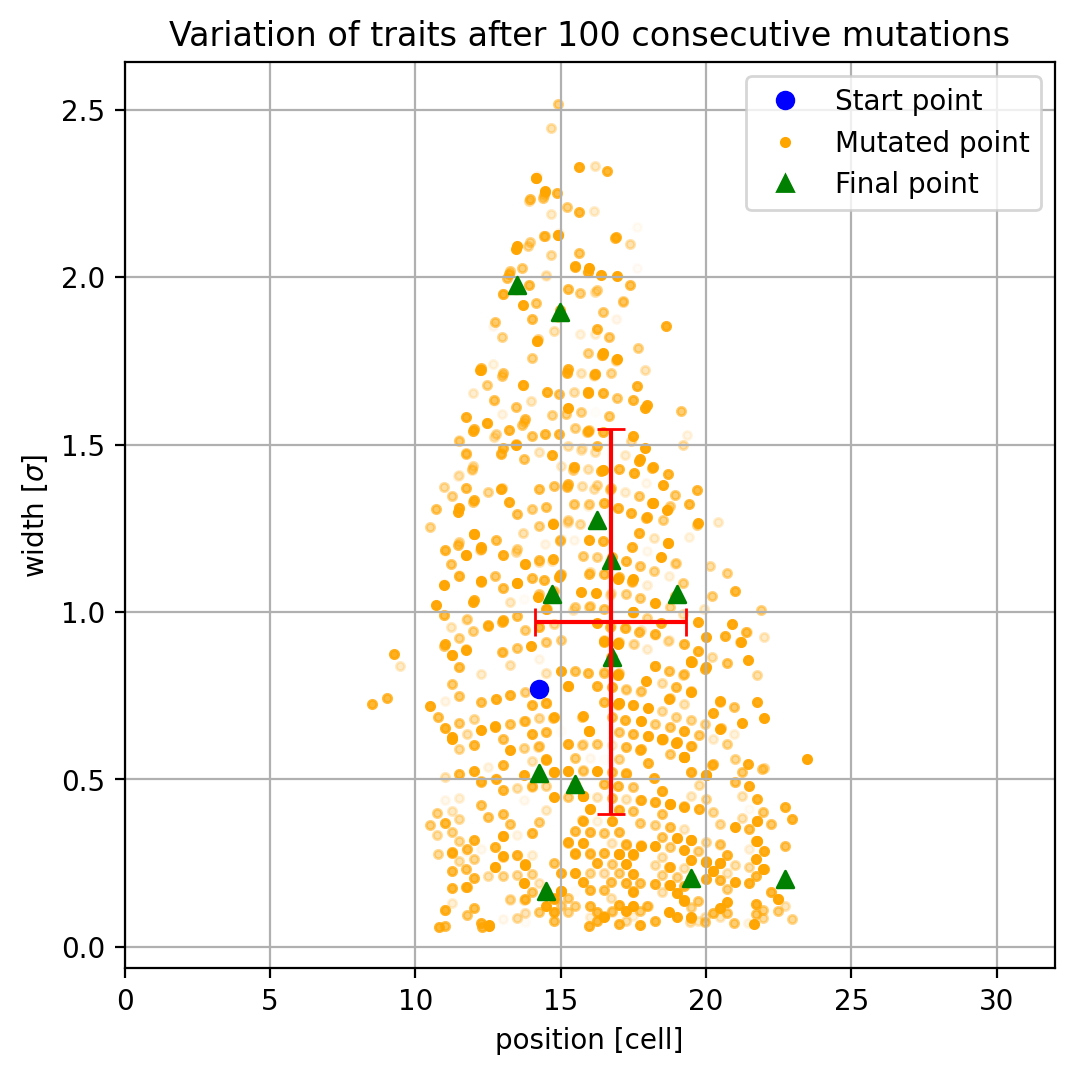

In [18]:
if writeDeviations:
    displayDeviations(initialPhenotypes, phenotypeHistories, averageDeviations, deviationUncertainties, numOfIterations)

In [19]:
position_aims = (22.5, 14.5, 18., 19., 0, 7.)
width_aims = (0.25, 1.2, 0.45, 1.3, 0, 0.22)


position_aim = position_aims[mechanismIndex]
width_aim = width_aims[mechanismIndex]


numOfReruns = 100 # min 5

numOfIterations = 1000

if writeConvergence:
    start_time = perf_counter()
    traitHistories, weightHistories, numOfMutations = rerunLoop(numOfReruns, numOfIterations, interactionWeights,
                                                         morphogenProfile,
                                                         xPoints, dx, dt, Ncells, Nspace,
                                                         Nsteps, diffConsts, decayConst,
                                                         dissociationConsts,
                                                         position_aim=position_aim, width_aim=width_aim,
                                                         position_units=deviationUncertainties[0],
                                                         width_units=deviationUncertainties[1])
    end_time = perf_counter()

    print(f'Simulation took: {(end_time - start_time)/60} minutes.')

    
    # Write to a file
    np.save(f'../data/traitHistories{mechanismIndex}_{subIndex}.npy', traitHistories)
    np.save(f'../data/weightHistories{mechanismIndex}_{subIndex}.npy', weightHistories)
    np.save(f'../data/numOfMutations{mechanismIndex}_{subIndex}.npy', numOfMutations)

else:
    traitHistories = np.load(f'../data/traitHistories{mechanismIndex}_{subIndex}.npy')
    weightHistories = np.load(f'../data/weightHistories{mechanismIndex}_{subIndex}.npy')
    numOfMutations = np.load(f'../data/numOfMutations{mechanismIndex}_{subIndex}.npy')

domain = list(map(lambda x: x[:,0,0]!=-1, weightHistories))
numOfAcceptedMutations = np.sum(domain, axis=1, dtype=int)
print(f'{100*(np.mean(numOfAcceptedMutations) / np.mean(numOfMutations))}'
        + '% acceptance rate')

5.303504957063355% acceptance rate


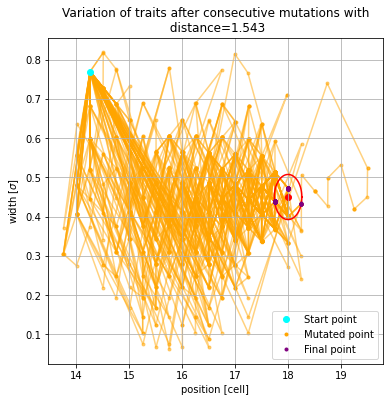

In [20]:
displayTraitHistory(traitHistories, initialPhenotypes, 
                    deviationUncertainties, position_aim=position_aim, width_aim=width_aim)

Square weight difference:
$$\Delta W = tr\Bigg(\Big(\underline{\underline{W_i}} - \underline{\underline{W_0}}\Big)\Big(\underline{\underline{W_i}} - \underline{\underline{W_0}}\Big)^T\Bigg)$$

Trait magnitude difference:
$$\Delta T = \sqrt{\Big(\frac{w_i - w_0}{e_w}\Big)^2 + \Big(\frac{x_i - x_0}{e_x}\Big)^2}$$

In [ ]:

startTime = perf_counter()
differenceHistory, traitHistory, weightHistory = timeConvergence(interactionWeights, 1000, morphogenProfile,
                                                    xPoints,dx, dt, Ncells, Nspace, Nsteps,
                                                    diffConsts, decayConst, dissociationConsts,
                                                    position_aim=position_aim, width_aim = width_aim,
                                                                 deviationUncertainties=deviationUncertainties)
endTime = perf_counter()
print(f'Simulation took: {endTime - startTime} seconds.')


displayConvergence(differenceHistory, traitHistory, position_aim, width_aim)

Did not converge


In [ ]:
displayTraitHistory(np.expand_dims(traitHistory, axis=0), initialPhenotypes, deviationUncertainties,
                    position_aim=position_aim, width_aim=width_aim) # [7]

# References

1. Dunn, N., 2022. Python Clocks Explained | Webucator. [online] Webucator.com. Available at: <https://www.webucator.com/article/python-clocks-explained/> [Accessed 21 July 2022].

2. Rodríguez, J., 2022. orb.plot() doesnt work for 32bit computer due to unsupported numba parallel target · Issue #1399 · poliastro/poliastro. [online] GitHub. Available at: <https://github.com/poliastro/poliastro/issues/1399> [Accessed 21 July 2022].

3. Moehlis, J., 2022. Numerical Solution of the Diffusion Equation with No-Flux Boundary Conditions. [online] Sites.me.ucsb.edu. Available at: <https://sites.me.ucsb.edu/~moehlis/APC591/tutorials/tutorial5/node6.html> [Accessed 21 July 2022].

4. Lescut, J., 2022. Multiple output and numba signatures. [online] Stack Overflow. Available at: <https://stackoverflow.com/questions/30363253/multiple-output-and-numba-signatures> [Accessed 21 July 2022].

5. User, 2022. Randomly generate 1 or -1 (positive or negative integer). [online] Stack Overflow. Available at: <https://stackoverflow.com/questions/46820182/randomly-generate-1-or-1-positive-or-negative-integer> [Accessed 21 July 2022].

6. Matplotlib.org. 2022. Legend guide — Matplotlib 3.5.2 documentation. [online] Available at: <https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html> [Accessed 21 July 2022].

7. Abbas, M., 2022. Add Dimension to NumPy Array. [online] Delft Stack. Available at: <https://www.delftstack.com/howto/numpy/python-numpy-add-dimension/> [Accessed 21 July 2022].


https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3010108/pdf/msb201074.pdf





